# Projet d'Apprentissage Automatique Non Supervisé
# Clustering des Hymnes Nationaux

**Membres du groupe :**
- Membre 1 Benjamin MAURY
- Membre 2 Haggar SENOUSSI
- Membre 3 Léo BOUFFARD

## Introduction

Ce projet vise à appliquer des techniques de clustering (apprentissage non supervisé) sur un ensemble de textes d'hymnes nationaux afin de découvrir des regroupements naturels entre les pays selon le contenu textuel de leurs hymnes. Nous analyserons ces clusters pour identifier d'éventuelles tendances ou similarités thématiques entre les différents pays.

Nous allons procéder en trois grandes étapes :
1. Prétraitement des textes d'hymnes nationaux
2. Application de l'algorithme des k-moyennes 
3. Application du clustering hiérarchique


## Importation des bibliothèques nécessaires

In [24]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Pour le prétraitement des textes
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Pour le clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

# Pour la visualisation
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from yellowbrick.cluster import SilhouetteVisualizer

# Téléchargement des ressources NLTK nécessaires
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\senou\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\senou\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\senou\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\senou\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\senou\AppData\Roaming\nltk_data...
[

True

# Chargemenr et exploration des données

In [25]:
# Chargement du jeu de données
df = pd.read_csv('data/anthems.csv')

# Affichage des premières lignes pour comprendre la structure
print("Aperçu du jeu de données :")
display(df.head())

# Informations générales sur le jeu de données
print("\nInformations sur le jeu de données :")
display(df.info())

# Statistiques descriptives
print("\nStatistiques descriptives :")
display(df.describe(include='all'))

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
display(df.isnull().sum())

# Nombre de pays dans le jeu de données
print(f"\nNombre de pays dans le jeu de données : {df.shape[0]}")

# Exploration de quelques exemples d'hymnes
print("\nExemples d'hymnes nationaux :")
for i in range(3):
    print(f"\nPays : {df.iloc[i]['Country']}")
    print(f"Extrait de l'hymne : {df.iloc[i]['Anthem'][:300]}...")

Aperçu du jeu de données :


,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."



Informations sur le jeu de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    190 non-null    object
 1   Alpha-2    189 non-null    object
 2   Alpha-3    190 non-null    object
 3   Continent  190 non-null    object
 4   Anthem     190 non-null    object
dtypes: object(5)
memory usage: 7.6+ KB


None


Statistiques descriptives :


,Country,Alpha-2,Alpha-3,Continent,Anthem
count,190,189,190,190,190
unique,190,188,190,6,188
top,Albania,CH,ALB,Africa,"Arise, ye who refuse to be slaves; With our ve..."
freq,1,2,1,56,2



Valeurs manquantes par colonne :


Country      0
Alpha-2      1
Alpha-3      0
Continent    0
Anthem       0
dtype: int64


Nombre de pays dans le jeu de données : 190

Exemples d'hymnes nationaux :

Pays : Albania
Extrait de l'hymne : Around our flag we stand united, With one wish and one goal, A sacred oath we bestow upon it Proclaiming loyalty for our salvation. From war abstains only he, Who a traitor is born, He who is a true man is not frightened, But dies a warrior to the cause. With weapons in our hands a-brandished, We wi...

Pays : Armenia
Extrait de l'hymne : Our Fatherland, free, independent, That has for centuries lived, Is now summoning its sons To the free, independent Armenia. Here is a flag for you, my brother, That I have sewn by hand Over the sleepless nights, And bathed in my tears. Look at it, tricolored, A valuable symbol for us. Let it shine ...

Pays : Austria
Extrait de l'hymne : Land of mountains, land by the river, Land of fields, land of cathedrals, Land of hammers, with a promising future! Home to great daughters and sons, People highly gifted for beautiful arts, Much-praised A

## Partie 1: Prétraitement des textes

### 1.1 Fonction de nettoyage superficiel

In [26]:
def nettoyage_superficiel(texte):
    """
    Effectue un nettoyage superficiel du texte :
    - Conversion en minuscules
    - Suppression des caractères spéciaux et de la ponctuation
    - Suppression des chiffres
    - Suppression des espaces multiples
    """
    if not isinstance(texte, str):
        return ""
    
    # Conversion en minuscules
    texte = texte.lower()
    
    # Suppression des URLs
    texte = re.sub(r'http\S+|www\S+|https\S+', '', texte)
    
    # Suppression des balises HTML si présentes
    texte = re.sub(r'<.*?>', '', texte)
    
    # Suppression des caractères spéciaux et de la ponctuation
    texte = re.sub(r'[^\w\s]', ' ', texte)
    
    # Suppression des chiffres
    texte = re.sub(r'\d+', '', texte)
    
    # Suppression des espaces multiples
    texte = re.sub(r'\s+', ' ', texte)
    
    # Suppression des espaces en début et fin de chaîne
    texte = texte.strip()
    
    return texte

# Application du nettoyage superficiel
df['anthem_clean'] = df['Anthem'].apply(nettoyage_superficiel)

# Affichage d'un exemple avant/après nettoyage
exemple_index = 0
print(f"Pays: {df.iloc[exemple_index]['Country']}")
print(f"\nHymne original:\n{df.iloc[exemple_index]['Anthem'][:500]}...")
print(f"\nHymne après nettoyage superficiel:\n{df.iloc[exemple_index]['anthem_clean'][:500]}...")

Pays: Albania

Hymne original:
Around our flag we stand united, With one wish and one goal, A sacred oath we bestow upon it Proclaiming loyalty for our salvation. From war abstains only he, Who a traitor is born, He who is a true man is not frightened, But dies a warrior to the cause. With weapons in our hands a-brandished, We will defend our fatherland, Our sacred rights weÃ¢â‚¬â„¢ll not relinquish, The foe has no place in our land. For God himself proclaimed The nations of the earth shall wane, And yet will live, will thriv...

Hymne après nettoyage superficiel:
around our flag we stand united with one wish and one goal a sacred oath we bestow upon it proclaiming loyalty for our salvation from war abstains only he who a traitor is born he who is a true man is not frightened but dies a warrior to the cause with weapons in our hands a brandished we will defend our fatherland our sacred rights weã â â ll not relinquish the foe has no place in our land for god himself proclaimed the nati

### 1.2 Suppression des stop words

In [27]:
def supprimer_stopwords(texte, langue='english'):
    """
    Supprime les stop words (mots vides) du texte.
    """
    if not isinstance(texte, str) or texte == "":
        return ""
    
    try:
        # Récupération des stop words pour la langue spécifiée
        # Vérification que les stopwords sont bien disponibles
        if langue not in stopwords.fileids():
            print(f"Attention: langue '{langue}' non disponible dans NLTK stopwords")
            print(f"Langues disponibles: {stopwords.fileids()}")
            # Utilisation d'une liste vide si la langue n'est pas disponible
            stop_words = set()
        else:
            stop_words = set(stopwords.words(langue))
        
        # Tokenisation du texte
        tokens = word_tokenize(texte)
        
        # Suppression des stop words
        tokens_filtered = [mot for mot in tokens if mot not in stop_words]
        
        # Reconstruction du texte
        texte_sans_stopwords = ' '.join(tokens_filtered)
        
        return texte_sans_stopwords
    
    except LookupError as e:
        print(f"Erreur NLTK: {e}")
        print("Essai de téléchargement des ressources manquantes...")
        nltk.download('stopwords')
        nltk.download('punkt')
        # Deuxième tentative après téléchargement
        return supprimer_stopwords(texte, langue)
    except Exception as e:
        print(f"Erreur inattendue: {e}")
        return texte  # Retourne le texte original en cas d'erreur

# Application de la suppression des stop words
# Ajout d'une gestion d'erreur au cas où
try:
    df['anthem_no_stopwords'] = df['anthem_clean'].apply(supprimer_stopwords)
except Exception as e:
    print(f"Erreur lors de la suppression des stop words: {e}")
    print("Utilisation du texte nettoyé sans suppression des stop words...")
    df['anthem_no_stopwords'] = df['anthem_clean']

# Affichage d'un exemple avant/après suppression des stop words
print(f"\nHymne après nettoyage superficiel:\n{df.iloc[exemple_index]['anthem_clean'][:500]}...")
print(f"\nHymne après suppression des stop words:\n{df.iloc[exemple_index]['anthem_no_stopwords'][:500]}...")


Hymne après nettoyage superficiel:
around our flag we stand united with one wish and one goal a sacred oath we bestow upon it proclaiming loyalty for our salvation from war abstains only he who a traitor is born he who is a true man is not frightened but dies a warrior to the cause with weapons in our hands a brandished we will defend our fatherland our sacred rights weã â â ll not relinquish the foe has no place in our land for god himself proclaimed the nations of the earth shall wane and yet will live will thrive albania for y...

Hymne après suppression des stop words:
around flag stand united one wish one goal sacred oath bestow upon proclaiming loyalty salvation war abstains traitor born true man frightened dies warrior cause weapons hands brandished defend fatherland sacred rights weã â â relinquish foe place land god proclaimed nations earth shall wane yet live thrive albania fight flag flag sacred symbol upon swear albania dear fatherland honour glory brave man named honoured

### 1.3 Racinisation et lemmatisation

In [28]:
# Initialisation des outils
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def racinisation(texte):
    """
    Applique la racinisation (stemming) aux mots du texte.
    """
    if not isinstance(texte, str) or texte == "":
        return ""
    
    # Tokenisation
    tokens = word_tokenize(texte)
    
    # Racinisation
    tokens_stemmed = [stemmer.stem(mot) for mot in tokens]
    
    # Reconstruction du texte
    texte_stemmed = ' '.join(tokens_stemmed)
    
    return texte_stemmed

def lemmatisation(texte):
    """
    Applique la lemmatisation aux mots du texte.
    """
    if not isinstance(texte, str) or texte == "":
        return ""
    
    # Tokenisation
    tokens = word_tokenize(texte)
    
    # Lemmatisation (par défaut considère les mots comme des noms)
    tokens_lemmatized = [lemmatizer.lemmatize(mot) for mot in tokens]
    
    # Reconstruction du texte
    texte_lemmatized = ' '.join(tokens_lemmatized)
    
    return texte_lemmatized

# Application de la racinisation et de la lemmatisation
df['anthem_stemmed'] = df['anthem_no_stopwords'].apply(racinisation)
df['anthem_lemmatized'] = df['anthem_no_stopwords'].apply(lemmatisation)

# Affichage des résultats pour un exemple
print(f"\nHymne après suppression des stop words:\n{df.iloc[exemple_index]['anthem_no_stopwords'][:300]}...")
print(f"\nHymne après racinisation:\n{df.iloc[exemple_index]['anthem_stemmed'][:300]}...")
print(f"\nHymne après lemmatisation:\n{df.iloc[exemple_index]['anthem_lemmatized'][:300]}...")

# Comparaison des résultats sur un petit échantillon de mots
exemple_texte = df.iloc[exemple_index]['anthem_no_stopwords']
tokens_exemple = word_tokenize(exemple_texte)[:10]
resultats_comparaison = pd.DataFrame({
    'Mot original': tokens_exemple,
    'Racinisation': [stemmer.stem(mot) for mot in tokens_exemple],
    'Lemmatisation': [lemmatizer.lemmatize(mot) for mot in tokens_exemple]
})
display(resultats_comparaison)

# Pour notre analyse, nous choisissons la lemmatisation car elle préserve mieux le sens des mots
texte_pretraite = df['anthem_lemmatized']


Hymne après suppression des stop words:
around flag stand united one wish one goal sacred oath bestow upon proclaiming loyalty salvation war abstains traitor born true man frightened dies warrior cause weapons hands brandished defend fatherland sacred rights weã â â relinquish foe place land god proclaimed nations earth shall wane yet liv...

Hymne après racinisation:
around flag stand unit one wish one goal sacr oath bestow upon proclaim loyalti salvat war abstain traitor born true man frighten die warrior caus weapon hand brandish defend fatherland sacr right weã â â relinquish foe place land god proclaim nation earth shall wane yet live thrive albania fight fl...

Hymne après lemmatisation:
around flag stand united one wish one goal sacred oath bestow upon proclaiming loyalty salvation war abstains traitor born true man frightened dy warrior cause weapon hand brandished defend fatherland sacred right weã â â relinquish foe place land god proclaimed nation earth shall wane yet live 

,Mot original,Racinisation,Lemmatisation
0,around,around,around
1,flag,flag,flag
2,stand,stand,stand
3,united,unit,united
4,one,one,one
5,wish,wish,wish
6,one,one,one
7,goal,goal,goal
8,sacred,sacr,sacred
9,oath,oath,oath


### 1.4 Analyse des fréquences des mots

Les 20 mots les plus fréquents dans les hymnes :
u: 249
land: 213
may: 154
god: 135
let: 135
people: 134
one: 108
nation: 105
free: 105
thy: 105
glory: 96
country: 94
shall: 93
homeland: 91
freedom: 90
love: 86
thee: 79
flag: 73
peace: 72
live: 71


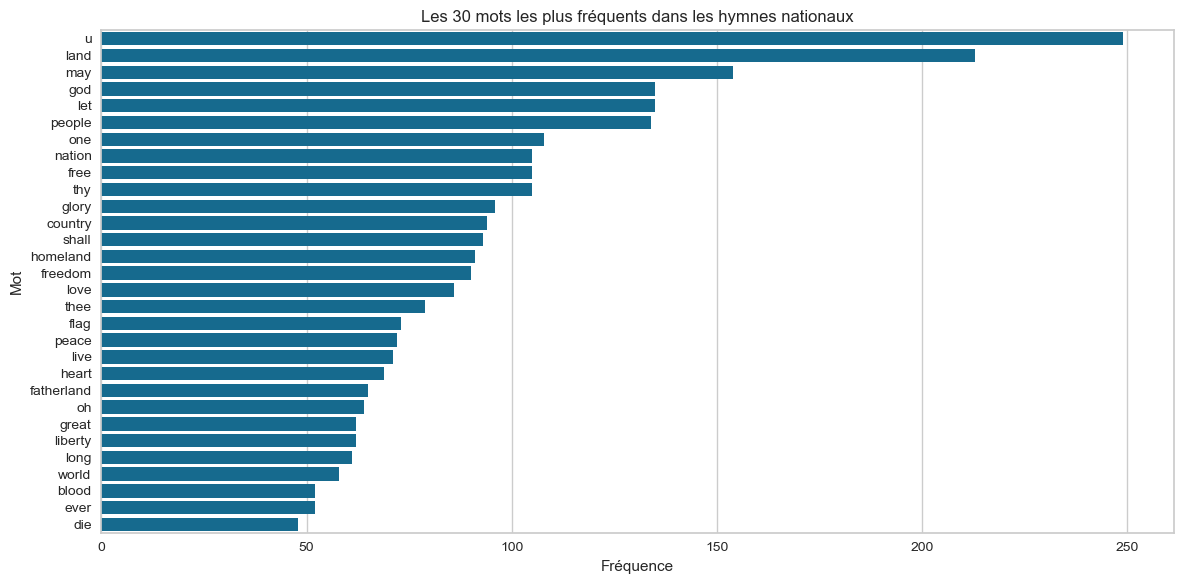

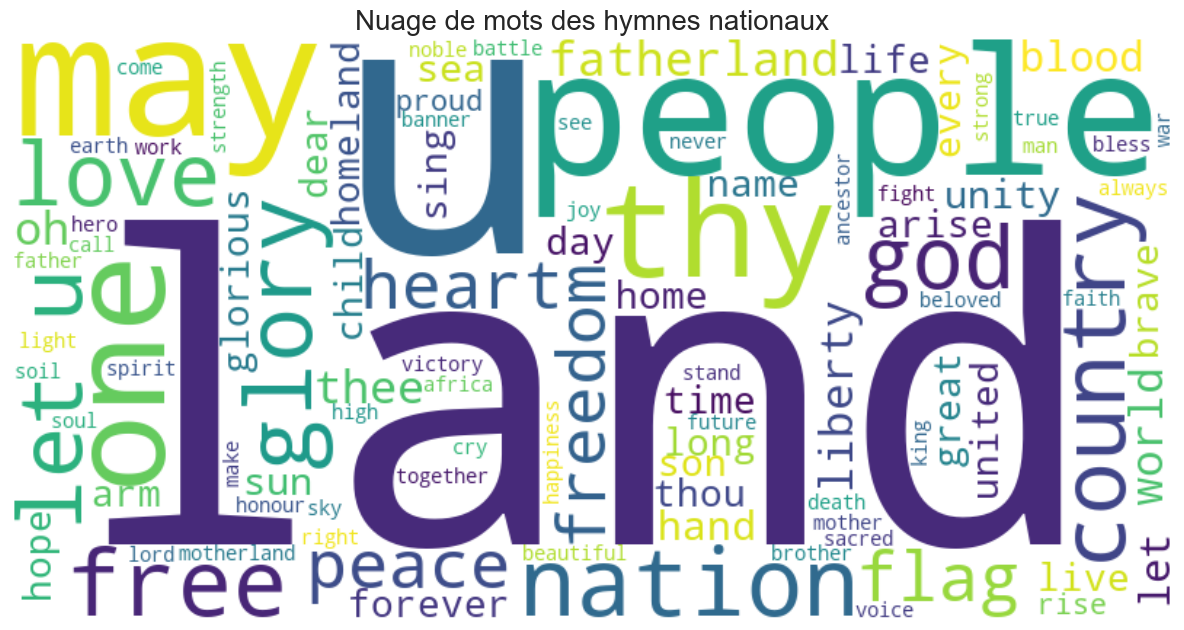

In [29]:
# Création d'un grand texte contenant tous les hymnes prétraités
tous_les_hymnes = ' '.join(df['anthem_lemmatized'].dropna())

# Tokenisation
tous_les_tokens = word_tokenize(tous_les_hymnes)

# Comptage des fréquences
freq_mots = Counter(tous_les_tokens)

# Affichage des 20 mots les plus fréquents
print("Les 20 mots les plus fréquents dans les hymnes :")
for mot, freq in freq_mots.most_common(20):
    print(f"{mot}: {freq}")

# Visualisation des 30 mots les plus fréquents
mots_freq = pd.DataFrame(freq_mots.most_common(30), columns=['Mot', 'Fréquence'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Fréquence', y='Mot', data=mots_freq)
plt.title('Les 30 mots les plus fréquents dans les hymnes nationaux')
plt.tight_layout()
plt.show()

# Nuage de mots global
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                     max_words=100, contour_width=3, contour_color='steelblue')
wordcloud.generate(tous_les_hymnes)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des hymnes nationaux', fontsize=20)
plt.tight_layout()
plt.show()

### 1.5 Vectorisation des textes

Dimensions de la matrice Bag of Words: (190, 1323)
Nombre de mots uniques dans le vocabulaire: 1323

Aperçu du vocabulaire:
abandon: index 0
able: index 1
abundance: index 2
accompanied: index 3
accord: index 4
achieve: index 5
achieved: index 6
acquired: index 7
across: index 8
action: index 9

Dimensions de la matrice TF-IDF: (190, 1323)

Aperçu de la matrice TF-IDF (5 premières lignes, 5 premières colonnes):


,abandon,able,abundance,accompanied,accord
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0



Mots les plus importants pour Albania:
  - sacred: 0.3243
  - fatherland: 0.2630
  - upon: 0.2280
  - flag: 0.2277
  - one: 0.2098

Mots les plus importants pour Armenia:
  - dy: 0.4513
  - independent: 0.3994
  - bathed: 0.2257
  - lived: 0.2153
  - free: 0.2152

Mots les plus importants pour Austria:
  - much: 0.4988
  - land: 0.2657
  - thou: 0.2169
  - bravely: 0.1663
  - continent: 0.1663


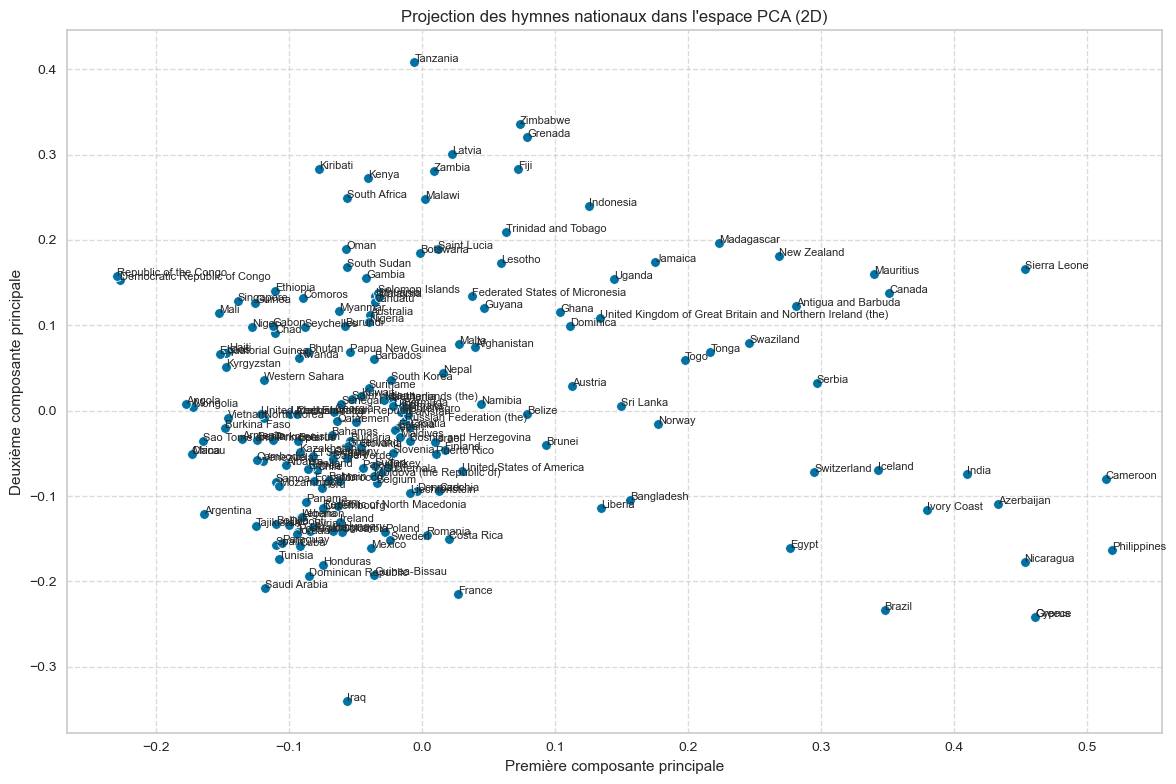

Variance expliquée par les deux premières composantes principales: 4.19%
Variance expliquée par la première composante: 2.41%
Variance expliquée par la deuxième composante: 1.78%


In [30]:
# Vectorisation avec CountVectorizer (Bag of Words)
count_vectorizer = CountVectorizer(min_df=2, max_df=0.95)
X_count = count_vectorizer.fit_transform(df['anthem_lemmatized'].fillna(''))

# Affichage de la forme de la matrice résultante
print(f"Dimensions de la matrice Bag of Words: {X_count.shape}")
print(f"Nombre de mots uniques dans le vocabulaire: {len(count_vectorizer.vocabulary_)}")

# Liste des mots dans le vocabulaire
print("\nAperçu du vocabulaire:")
vocab_count = count_vectorizer.vocabulary_
vocab_items = list(vocab_count.items())
for i, (mot, index) in enumerate(sorted(vocab_items, key=lambda x: x[1])[:10]):
    print(f"{mot}: index {index}")

# Vectorisation avec TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(df['anthem_lemmatized'].fillna(''))

print(f"\nDimensions de la matrice TF-IDF: {X_tfidf.shape}")

# Conversion en DataFrame pour plus de lisibilité
feature_names = tfidf_vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# Affichage d'un aperçu de la matrice TF-IDF
print("\nAperçu de la matrice TF-IDF (5 premières lignes, 5 premières colonnes):")
display(df_tfidf.iloc[:5, :5])

# Pour chaque hymne, trouver les 5 mots les plus importants selon TF-IDF
def mots_importants_tfidf(index_pays, n=5):
    """Retourne les n mots les plus importants pour un pays donné selon TF-IDF."""
    tfidf_scores = list(zip(feature_names, X_tfidf[index_pays].toarray()[0]))
    tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    return tfidf_scores[:n]

# Affichage des mots les plus importants pour 3 pays
for i in range(3):
    pays = df.iloc[i]['Country']
    mots_top = mots_importants_tfidf(i)
    print(f"\nMots les plus importants pour {pays}:")
    for mot, score in mots_top:
        print(f"  - {mot}: {score:.4f}")

# Sauvegarde des matrices de vectorisation pour les prochaines étapes
# Pour notre analyse, nous utiliserons la matrice TF-IDF qui capture mieux l'importance des mots
X = X_tfidf

# Ajout d'une réduction de dimension PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Création d'un DataFrame pour faciliter la visualisation
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Country'] = df['Country'].values

# Visualisation des pays dans l'espace PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', data=df_pca)

# Ajout des noms de pays comme annotations
for i, row in df_pca.iterrows():
    plt.annotate(row['Country'], (row['PC1'], row['PC2']), fontsize=8)

plt.title('Projection des hymnes nationaux dans l\'espace PCA (2D)')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Variance expliquée par les composantes principales
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par les deux premières composantes principales: {sum(explained_variance):.2%}")
print(f"Variance expliquée par la première composante: {explained_variance[0]:.2%}")
print(f"Variance expliquée par la deuxième composante: {explained_variance[1]:.2%}")

## Résumé du prétraitement et préparation pour le clustering

In [31]:
# Résumé des étapes de prétraitement effectuées
print("Résumé des étapes de prétraitement effectuées :")
print("1. Nettoyage superficiel des textes (minuscules, suppression de ponctuation, etc.)")
print("2. Suppression des stop words (mots vides)")
print("3. Normalisation sémantique par lemmatisation")
print("4. Vectorisation des textes avec TF-IDF")
print("5. Réduction de dimension avec PCA pour visualisation")

# Préparation des données pour le clustering
# Nous utiliserons la matrice TF-IDF (X) pour les parties suivantes du projet

# Sauvegarde des données prétraitées pour les membres du groupe
# qui s'occuperont du clustering
# Remove 'Country' column from df_pca to avoid overlap
df_pca_no_country = df_pca.drop(columns=['Country'])

data_for_clustering = {
    'X_tfidf': X_tfidf,
    'X_pca': X_pca,
    'df_with_features': df.join(df_pca_no_country)}

# On peut aussi sauvegarder ces données dans un fichier pour faciliter le travail des autres membres
# Exemple:
# with open('data_for_clustering.pkl', 'wb') as f:
#     pickle.dump(data_for_clustering, f)

print("\nLes données sont prêtes pour les étapes de clustering!")

Résumé des étapes de prétraitement effectuées :
1. Nettoyage superficiel des textes (minuscules, suppression de ponctuation, etc.)
2. Suppression des stop words (mots vides)
3. Normalisation sémantique par lemmatisation
4. Vectorisation des textes avec TF-IDF
5. Réduction de dimension avec PCA pour visualisation

Les données sont prêtes pour les étapes de clustering!
